# Neural Language Model - RNN (Recurrent Neural Network)

RNN-based architectures (such as, LSTM, GRU, etc) is widely used in today's NLP.

Recall that language model created in [previous example](./05_language_model_basic.ipynb) won't care the long past context.<br>
For example, when the following sentence is given,

"In the United States, the president has now been"

it won't care the context "In the United States" when it refers only the last 5 words.<br>
There might then be inconsistency in the sentence between former part and latter part.

Let me assume another sentence "it's vulgar and mean, but I liked it.".<br>
This sentence includes some negative phrases ("vulgar", "mean"), but the overall sentence has positive sentiment. This example shows that it's needed for precise predictions to understand not only individual phrases, but also the context in which they occur.

In recurrent architecture, past context (called states) is inherited to the next prediction by the state memory $ s $ (which is trained by input and previous state), and this connection continues in the chain as follows. (See the following diagram.)<br>
In this network, the next state $s_{i+1}$ is predicted by input $x_i$ and previous state $s_i$ in the network $R$ (which is called a recurrent unit) and this will be connected from beginning to the end of sequence. The output $y$ in each recurrent unit is generated by the state $s$ and the function $f(\cdot)$. The output $y$ is then used for prediction in each unit.

> Note : In simple RNN and GRU, $ f(\cdot) $ in the following diagram is identity function.

Recurrent Neural Network (RNN) will then be able to represent arbitrary size of sequence.

![recurrent architecture](images/rnn_architecture.png)

There are a lot of variants (including today's state-of-the-art model) in recurrent architecture.

In **bidirectional RNN (BiRNN)**, the states in both directions (forward states and backward states) are maintained and trained as follows.

![bidirectional rnn](images/bidirectional_rnn.png)

Imagine that you predict the word [jumped] in the sentence, "the brown fox [xxxxx] over the dog". In this example, the latter context ("over the dog") is also important in the prediction.<br>
The bidirectional RNN (BiRNN) is very effective, also in tagging tasks.

In **deep RNN** (see below), the output is more deeply learned by multi-layered architecture. (See the following picture.)

![deep rnn](images/deep_rnn.png)

One of successful architecture in RNN is recurrent **gated architecture**.<br>
With simple RNN, it will suffer from vanishing gradient problems, with which a lot of layers will rapidly lead the gradients of loss to zeros. (It will then eventually become hard to train the long past context in sequence.)<br>
Briefly saying, gated architecture will avoid this problem by using gate vector $ g $ and new memory $ s^{\prime} $ as follows :

$ s^{\prime} = g \cdot x + (1 - g) \cdot s $

where $ \cdot $ is inner product operation and $1$ is vector $(1,1,\ldots,1)$.

This computation will read the entries of input $ x $ which correspond to 1 values in $ g $, and read the entries of state $ s $ which correspond to 0 values in $ g $.<br>
$ g $ is then also controlled and trained by input and previous memory state.

**LSTM (Long Short Term Memory)** and **GRU (Gated Recurrent Unit)** are widely used gated architectures in language tasks.<br>
I'll show you GRU in the following diagram.

![gru architecture](images/gru_gate.png)

$$ R : r_i = \sigma(W_{rx} x_i + W_{rs} s_{i-1}) $$
$$ Z : z_i = \sigma(W_{zx} x_i + W_{zs} s_{i-1}) $$

$$ \tilde{S} : \tilde{s}_i = tanh(W_{sx} x_i + W_{ss} (r_i \cdot s_{i-1})) $$
$$ S : s_i = (1 - z_i) \cdot s_{i-1} + z_i \cdot \tilde{s}_i $$

where $ \sigma(\cdot) $ is sigmoid activation and $ tanh(\cdot) $ is tanh activation. (See [here](https://tsmatz.wordpress.com/2017/08/30/regression-in-machine-learning-math-for-beginners/) for sigmoid and tanh operation.)

> Note : The bias term is often included, such as $ Z : z_i = \sigma(W_{zx} x_i + W_{zs} s_{i-1} + b_z) $.

In GRU architecture, the new state candidate $ \tilde{s}_i $ is computed by using the controlled parameter $ r_i $. (And $ r_i $ is also trained by inputs.)<br>
The updated final state $ s_i $ is then determined based on the weight between previous state $ s_{i-1} $ and state candidate $ \tilde{s}_i $, by using controlled parameter $ z_i $. (And $ z_i $ is also trained by inputs.)

In this example, we will train 2 language models with simple RNN (Simple Recurrent Neural Network) and GRU (Gated Recurrent Unit) architecture in word's prediction task.

*back to [index](https://github.com/tsmatz/nlp-tutorials/)*

## Install required packages

## Prepare data

In this example, I have used short description text in news papers dataset, since it's formal-styled concise sentence (not including slangs and it's today's modern English).<br>
Before starting, please download [News_Category_Dataset_v2.json](https://www.kaggle.com/datasets/rmisra/news-category-dataset/versions/2) (collected by HuffPost) in Kaggle.

In [1]:
import pandas as pd

df = pd.read_json("News_Category_Dataset_v2.json",lines=True)
max_len = 1024
train_data = df["short_description"].iloc[:max_len]
train_data.shape

(1024,)

To get the better performance (accuracy), we standarize the input text as follows.
- Make all words to lowercase in order to reduce words
- Make "-" (hyphen) to space
- Remove all punctuation except " ' " (e.g, don't, isn't) and "&" (e.g, AT&T)

In [2]:
import pandas as pd

train_data = pd.Series(train_data)

train_data = train_data.str.lower()
train_data = train_data.str.replace("-", " ", regex=True)
train_data = train_data.str.replace(r"[^'\&\w\s]", "", regex=True)
train_data = train_data.str.strip()

train_data


0       she left her husband he killed their children ...
1                                 of course it has a song
2       the actor and his longtime girlfriend anna ebe...
3       the actor gives dems an ass kicking for not fi...
4       the dietland actress said using the bags is a ...
                              ...                        
1019    at least 16 states debated bills to regulate t...
1020    snl alum piscopo blasted the sketch featuring ...
1021                                                 ewww
1022      the new yorker has vetted four women's accounts
1023    tech is created by humans and its vulnerable t...
Name: short_description, Length: 1024, dtype: object

Finally we add ```<start>``` and ```<end>``` tokens in each sequence as follows, because these are important information for learning the ordered sequence.

```this is a pen``` --> ```<start> this is a pen <end>```

In [3]:
train_data = [" ".join(["<start>", x, "<end>"]) for x in train_data]
# print first row
train_data[0]

'<start> she left her husband he killed their children just another day in america <end>'

## Generate sequence inputs

We will generate the sequence of word's indices (i.e, tokenize) from text.

![Index vectorize](images/index_vectorize2.png)

First we create a list of vocabulary (```vocab```).

In [4]:
from nltk.tokenize import SpaceTokenizer

###
# define Vocab
###
class Vocab:
    def __init__(self, list_of_sentence, tokenization, special_token, max_tokens=None):
        # count vocab frequency
        vocab_freq = {}
        tokens = tokenization(list_of_sentence)
        for t in tokens:
            for vocab in t:
                if vocab not in vocab_freq:
                    vocab_freq[vocab] = 0
                vocab_freq[vocab] += 1
        # sort by frequency
        vocab_freq = {k: v for k, v in sorted(vocab_freq.items(), key=lambda i: i[1], reverse=True)}
        # create vocab list
        self.vocabs = [special_token] + list(vocab_freq.keys())
        if max_tokens:
            self.vocabs = self.vocabs[:max_tokens]
        self.stoi = {v: i for i, v in enumerate(self.vocabs)}

    def _get_tokens(self, list_of_sentence):
        for sentence in list_of_sentence:
            tokens = tokenizer.tokenize(sentence)
            yield tokens

    def get_itos(self):
        return self.vocabs

    def get_stoi(self):
        return self.stoi

    def append_token(self, token):
        self.vocabs.append(token)
        self.stoi = {v: i for i, v in enumerate(self.vocabs)}

    def __call__(self, list_of_tokens):
        def get_token_index(token):
            if token in self.stoi:
                return self.stoi[token]
            else:
                return 0
        return [get_token_index(t) for t in list_of_tokens]

    def __len__(self):
        return len(self.vocabs)

###
# generate Vocab
###
max_word = 50000

# create tokenizer
tokenizer = SpaceTokenizer()

# define tokenization function
def yield_tokens(data):
    for text in data:
        tokens = tokenizer.tokenize(text)
        yield tokens

# build vocabulary list
vocab = Vocab(
    train_data,
    tokenization=yield_tokens,
    special_token="<unk>",
    max_tokens=max_word,
)

The generated token index is ```0, 1, ... , vocab_size - 1```.<br>
Now I set ```vocab_size``` (here 50000) as a token id in padded positions.

In [5]:
pad_index = vocab.__len__()
vocab.append_token("<pad>")

Get list for both index-to-word and word-to-index.

In [6]:
itos = vocab.get_itos()
stoi = vocab.get_stoi()

In [7]:
# test
print("The number of token index is {}.".format(vocab.__len__()))
print("The padded index is {}.".format(stoi["<pad>"]))

The number of token index is 4316.
The padded index is 4315.


Now we build a collator function, which is used for pre-processing in data loader.

In this collator, first we create a list of word's indices as follows.

```<start> this is pen <end>``` --> ```[2, 7, 5, 14, 1]```

Next we separate into features (x) and labels (y).<br>
In this task, we predict the next word in the sequence, and we then create the following features (x) and labels (y) in each row.

<u>before</u> :

```[2, 7, 5, 14, 1]```

<u>after</u> :

```x : [2, 7, 5, 14, 1]```

```y : [7, 5, 14, 1, -100]```

> Note : Here I set -100 as an unknown label id, because PyTorch cross-entropy function (```torch.nn.functional.cross_entropy()```) has a property ```ignore_index``` which default value is -100.

Finally we pad the inputs as follows.<br>
The padded index in features is ```pad_index``` and the padded index in label is -100. (See above note.)

```x : [2, 7, 5, 14, 1, N, ... , N]```

```y : [7, 5, 14, 1, -100, -100, ... , -100]```

In [8]:
import torch
from torch.utils.data import DataLoader

max_seq_len = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, feature_list = [], []
    for text in batch:
        # tokenize to a list of word's indices
        tokens = vocab(tokenizer.tokenize(text))
        # separate into features and labels
        y = tokens[1:]
        y.append(-100)
        x = tokens
        # limit length to max_seq_len
        y = y[:max_seq_len]
        x = x[:max_seq_len]
        # pad features and labels
        y += [-100] * (max_seq_len - len(y))
        x += [pad_index] * (max_seq_len - len(x))
        # add to list
        label_list.append(y)
        feature_list.append(x)
    # convert to tensor
    label_list = torch.tensor(label_list, dtype=torch.int64).to(device)
    feature_list = torch.tensor(feature_list, dtype=torch.int64).to(device)
    return label_list, feature_list

dataloader = DataLoader(
    train_data,
    batch_size=16,
    shuffle=True,
    collate_fn=collate_batch
)

In [9]:
# test
for labels, features in dataloader:
    break

print("label shape in batch : {}".format(labels.size()))
print("feature shape in batch : {}".format(features.size()))
print("***** label sample *****")
print(labels[0])
print("***** features sample *****")
print(features[0])

label shape in batch : torch.Size([16, 128])
feature shape in batch : torch.Size([16, 128])
***** label sample *****
tensor([   3, 2831,    6,   73, 2832, 2833, 2834,  239,  372, 2835, 2836, 2837,
           7,  859,    2, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100])
***** features sample ****

## Build network

Now we build a model for this next word's prediction using simple RNN architecture.

![RNN network](images/rnn_network.png)

In PyTorch, you can use ```torch.nn.RNN``` module for processing simple RNN, and we also use this built-in module in this example.

In the following example, the shape of RNN input is expected to be ```(batch_size, sequence_length, input_dimension)```.<br>
However, to tell which time steps in each sequence should be processed in RNN (i.e, for RNN masking), we wrap this tensor as a packed sequence with ```torch.nn.utils.rnn.pack_padded_sequence()``` before passing into RNN module.<br>
For example, when batch size is 4 and we generate a packed sequence with ```lengths=[5, 3, 3, 2]``` in ```torch.nn.utils.rnn.pack_padded_sequence()```, the processed sequence# in each time-step will then be :

```
time-step 1 : {1, 2, 3, 4}
time-step 2 : {1, 2, 3, 4}
time-step 3 : {1, 2, 3}
time-step 4 : {1}
time-step 5 : {1}
```

As a result, it's processed with new batch size ```[4, 4, 3, 1, 1]```. (See below picture.)

![packed sequence](images/rnn_packed_sequence.png)

> Note : When the length is not sorted, first all sequences in batch are sorted by descending length of sequence, and planned to run batches to meet each time-steps. (When it's unpacked, the order is returned to the original position.)

In [10]:
import torch
import torch.nn as nn

embedding_dim = 64
rnn_units = 256

class SimpleRnnModel(nn.Module):
    def __init__(self, vocab_size, seq_len, embedding_dim, rnn_units, padding_idx):
        super().__init__()

        self.seq_len = seq_len
        self.padding_idx = padding_idx

        self.embedding = nn.Embedding(
            vocab_size,
            embedding_dim,
            padding_idx=padding_idx,
        )
        self.rnn = nn.RNN(
            input_size=embedding_dim,
            hidden_size=rnn_units,
            num_layers=1,
            batch_first=True,
        )
        self.classify = nn.Linear(rnn_units, vocab_size)

    def forward(self, inputs, states=None, return_final_state=False):
        # embedding
        #   --> (batch_size, seq_len, embedding_dim)
        outs = self.embedding(inputs)
        # build "lengths" property to pack inputs (see above)
        lengths = (inputs != self.padding_idx).int().sum(dim=1, keepdim=False)
        # pack inputs for RNN
        packed_inputs = torch.nn.utils.rnn.pack_padded_sequence(
            outs,
            lengths.cpu(),
            batch_first=True,
            enforce_sorted=False,
        )
        # apply RNN
        if states is None:
            packed_outs, final_state = self.rnn(packed_inputs)
        else:
            packed_outs, final_state = self.rnn(packed_inputs, states)
        # unpack results
        #   --> (batch_size, seq_len, rnn_units)
        outs, _ = torch.nn.utils.rnn.pad_packed_sequence(
            packed_outs,
            batch_first=True,
            padding_value=0.0,
            total_length=self.seq_len,
        )
        # apply feed-forward to classify
        #   --> (batch_size, seq_len, vocab_size)
        logits = self.classify(outs)
        # return results
        if return_final_state:
            return logits, final_state  # This is used in prediction
        else:
            return logits               # This is used in training

model = SimpleRnnModel(
    vocab_size=vocab.__len__(),
    seq_len=max_seq_len,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    padding_idx=pad_index).to(device)

## Train

Now run training with above model.

As I have mentioned above, the loss on label id=-100 is ignored in ```cross_entropy()``` function. The padded position and the end of sequence will then be ignored in optimization.

> Note : Because the default value of  ```ignore_index``` property in ```cross_entropy()``` function is -100. (You can change this default value.)

In [37]:
from torch.nn import functional as F
import time
import math

num_epochs = 30

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# lists to track history
rnn_loss_history = []
rnn_acc_history = []
rnn_ppl_history = []

# track time
rnn_start_time = time.time()

for epoch in range(num_epochs):
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for labels, seqs in dataloader:
        # optimize
        optimizer.zero_grad()
        logits = model(seqs)
        loss = F.cross_entropy(logits.transpose(1,2), labels)
        loss.backward()
        optimizer.step()

        # accum stats
        running_loss += loss.item()

        # calculate accuracy
        pred_labels = logits.argmax(dim=2)
        num_correct = (pred_labels == labels).float().sum()
        num_total = (labels != -100).float().sum()

        running_correct += num_correct.item()
        running_total += num_total.item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = running_correct / running_total
    epoch_ppl = math.exp(epoch_loss)

    rnn_loss_history.append(epoch_loss)
    rnn_acc_history.append(epoch_acc)
    rnn_ppl_history.append(epoch_ppl)

    print("Epoch {} - loss: {:2.4f} - accuracy: {:2.4f} - perplexity: {:2.4f}".format(epoch+1, epoch_loss, epoch_acc, epoch_ppl))

rnn_end_time = time.time()
print(f"RNN Training Time: {rnn_end_time - rnn_start_time:.2f} seconds")
torch.save(model.state_dict(), "modelrnn.pkl")


Epoch 1 - loss: 7.4028 - accuracy: 0.0753 - perplexity: 1640.6350
Epoch 2 - loss: 6.6209 - accuracy: 0.1010 - perplexity: 750.6289
Epoch 3 - loss: 6.2987 - accuracy: 0.1121 - perplexity: 543.8456
Epoch 4 - loss: 5.9515 - accuracy: 0.1176 - perplexity: 384.3426
Epoch 5 - loss: 5.5696 - accuracy: 0.1311 - perplexity: 262.3228
Epoch 6 - loss: 5.1678 - accuracy: 0.1415 - perplexity: 175.5204
Epoch 7 - loss: 4.7555 - accuracy: 0.1580 - perplexity: 116.2191
Epoch 8 - loss: 4.3248 - accuracy: 0.1923 - perplexity: 75.5472
Epoch 9 - loss: 3.9090 - accuracy: 0.2485 - perplexity: 49.8473
Epoch 10 - loss: 3.5043 - accuracy: 0.3250 - perplexity: 33.2568
Epoch 11 - loss: 3.1369 - accuracy: 0.3971 - perplexity: 23.0331
Epoch 12 - loss: 2.8031 - accuracy: 0.4609 - perplexity: 16.4962
Epoch 13 - loss: 2.5118 - accuracy: 0.5231 - perplexity: 12.3268
Epoch 14 - loss: 2.2670 - accuracy: 0.5748 - perplexity: 9.6506
Epoch 15 - loss: 2.0511 - accuracy: 0.6180 - perplexity: 7.7763
Epoch 16 - loss: 1.8636 - ac

## Generate Text (Simple RNN)

Here I simply generate several text with trained model.

The metrics to evaluate text generation task is not so easy. (Because simply checking an exact match to a reference text is not optimal.)<br>
Use some common metrics available in these cases, such as, BLEU or ROUGE.

> Note : Here I use greedy search and this will sometimes lead to wrong sequence. For drawbacks and solutions, see note in [this example](./05_language_model_basic.ipynb).

In [39]:
print(pred_output("home"))


<start> home have the president barack obama she and the bathrooms of our players and take have been working with the trump administration in recent weeks in an attempt to change the president's mind <end>


## Train with GRU

Next we train the same task with gated architecture, GRU (gated recurrent unit).<br>
As I have mentioned above, GRU layer has following architecture.

![gru architecture](images/gru_gate.png)

$$ R : r_i = \sigma(W_{rx} x_i + W_{rs} s_{i-1}) $$
$$ Z : z_i = \sigma(W_{zx} x_i + W_{zs} s_{i-1}) $$

$$ \tilde{S} : \tilde{s}_i = tanh(W_{sx} x_i + W_{ss} (r_i \cdot s_{i-1})) $$
$$ S : s_i = (1 - z_i) \cdot s_{i-1} + z_i \cdot \tilde{s}_i $$

In this example, we use built-in layer ```torch.nn.GRU``` in PyTorch.

> Note : In the following example, we use bias term in GRU layer.

In [11]:
embedding_dim = 64
rnn_units = 256

class GruModel(nn.Module):
    def __init__(self, vocab_size, seq_len, embedding_dim, rnn_units, padding_idx):
        super().__init__()

        self.seq_len = seq_len
        self.padding_idx = padding_idx

        self.embedding = nn.Embedding(
            vocab_size,
            embedding_dim,
            padding_idx=padding_idx,
        )
        self.rnn = nn.GRU(
            input_size=embedding_dim,
            hidden_size=rnn_units,
            num_layers=1,
            batch_first=True,
        )
        self.classify = nn.Linear(rnn_units, vocab_size)

    def forward(self, inputs, states=None, return_final_state=False):
        # embedding
        #   --> (batch_size, seq_len, embedding_dim)
        outs = self.embedding(inputs)
        # build "lengths" property to pack inputs (see above)
        lengths = (inputs != self.padding_idx).int().sum(dim=1, keepdim=False)
        # pack inputs for RNN
        packed_inputs = torch.nn.utils.rnn.pack_padded_sequence(
            outs,
            lengths.cpu(),
            batch_first=True,
            enforce_sorted=False,
        )
        # apply RNN
        if states is None:
            packed_outs, final_state = self.rnn(packed_inputs)
        else:
            packed_outs, final_state = self.rnn(packed_inputs, states)
        # unpack results
        #   --> (batch_size, seq_len, rnn_units)
        outs, _ = torch.nn.utils.rnn.pad_packed_sequence(
            packed_outs,
            batch_first=True,
            padding_value=0.0,
            total_length=self.seq_len,
        )
        # apply feed-forward to classify
        #   --> (batch_size, seq_len, vocab_size)
        logits = self.classify(outs)
        # return results
        if return_final_state:
            return logits, final_state  # This is used in prediction
        else:
            return logits               # This is used in training

model = GruModel(
    vocab_size=vocab.__len__(),
    seq_len=max_seq_len,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    padding_idx=pad_index).to(device)

In [41]:
import time
import math

num_epochs = 30

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# lists to track history
gru_loss_history = []
gru_acc_history = []
gru_ppl_history = []

# track time
gru_start_time = time.time()

for epoch in range(num_epochs):
    running_loss = 0.0
    running_correct = 0
    running_total = 0
    for labels, seqs in dataloader:
        # optimize
        optimizer.zero_grad()
        logits = model(seqs)
        loss = F.cross_entropy(logits.transpose(1,2), labels)
        loss.backward()
        optimizer.step()

        # accum stats
        running_loss += loss.item()

        # calculate accuracy
        pred_labels = logits.argmax(dim=2)
        num_correct = (pred_labels == labels).float().sum()
        num_total = (labels != -100).float().sum()

        running_correct += num_correct.item()
        running_total += num_total.item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = running_correct / running_total
    epoch_ppl = math.exp(epoch_loss)

    gru_loss_history.append(epoch_loss)
    gru_acc_history.append(epoch_acc)
    gru_ppl_history.append(epoch_ppl)

    print("Epoch {} - loss: {:2.4f} - accuracy: {:2.4f} - perplexity: {:2.4f}".format(epoch+1, epoch_loss, epoch_acc, epoch_ppl))

gru_end_time = time.time()
print(f"GRU Training Time: {gru_end_time - gru_start_time:.2f} seconds")

Epoch 1 - loss: 7.4531 - accuracy: 0.0820 - perplexity: 1725.2489
Epoch 2 - loss: 6.6555 - accuracy: 0.1009 - perplexity: 777.0230
Epoch 3 - loss: 6.3612 - accuracy: 0.1112 - perplexity: 578.9472
Epoch 4 - loss: 6.0283 - accuracy: 0.1200 - perplexity: 415.0103
Epoch 5 - loss: 5.6567 - accuracy: 0.1278 - perplexity: 286.2094
Epoch 6 - loss: 5.2539 - accuracy: 0.1395 - perplexity: 191.3043
Epoch 7 - loss: 4.8284 - accuracy: 0.1531 - perplexity: 125.0072
Epoch 8 - loss: 4.4023 - accuracy: 0.1849 - perplexity: 81.6391
Epoch 9 - loss: 3.9723 - accuracy: 0.2393 - perplexity: 53.1078
Epoch 10 - loss: 3.5579 - accuracy: 0.3072 - perplexity: 35.0884
Epoch 11 - loss: 3.1709 - accuracy: 0.3819 - perplexity: 23.8300
Epoch 12 - loss: 2.8338 - accuracy: 0.4480 - perplexity: 17.0095
Epoch 13 - loss: 2.5297 - accuracy: 0.5120 - perplexity: 12.5499
Epoch 14 - loss: 2.2618 - accuracy: 0.5716 - perplexity: 9.6004
Epoch 15 - loss: 2.0192 - accuracy: 0.6228 - perplexity: 7.5324
Epoch 16 - loss: 1.8049 - ac

# Generate Text (GRU)

Here I simply generate several text with trained model.

The metrics to evaluate text generation task is not so easy. (Because simply checking an exact match to a reference text is not optimal.)<br>
Use some common metrics available in these cases, such as, BLEU or ROUGE.

> Note : Here I use greedy search and this will sometimes lead to wrong sequence. For drawbacks and solutions, see note in [this example](./05_language_model_basic.ipynb).

In [43]:
torch.save(model.state_dict(), "modelgru.pkl")


## Compare Models
We compare the performance (Loss and Accuracy) and training time between Simple RNN and GRU.

Simple RNN Total Training Time: 1128.04 s
GRU Total Training Time: 1211.84 s


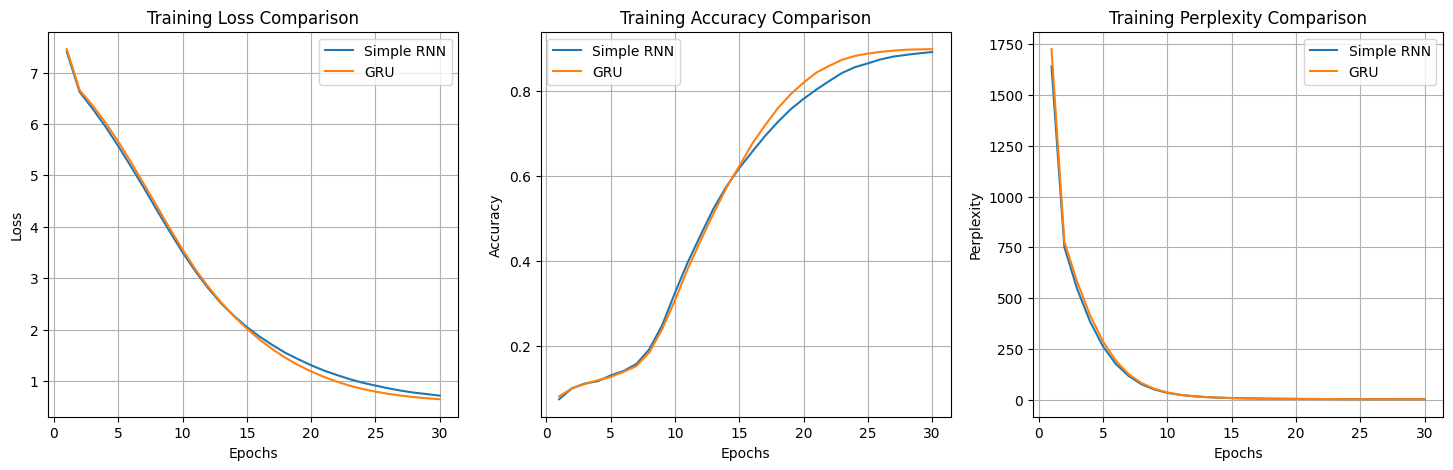

In [44]:
import matplotlib.pyplot as plt

# Comparison of Training Time
rnn_duration = rnn_end_time - rnn_start_time
gru_duration = gru_end_time - gru_start_time

print(f"Simple RNN Total Training Time: {rnn_duration:.2f} s")
print(f"GRU Total Training Time: {gru_duration:.2f} s")

# Comparison charts
plt.figure(figsize=(18, 5))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(range(1, len(rnn_loss_history) + 1), rnn_loss_history, label='Simple RNN')
plt.plot(range(1, len(gru_loss_history) + 1), gru_loss_history, label='GRU')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(range(1, len(rnn_acc_history) + 1), rnn_acc_history, label='Simple RNN')
plt.plot(range(1, len(gru_acc_history) + 1), gru_acc_history, label='GRU')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Comparison')
plt.legend()
plt.grid(True)

# Plot Perplexity
plt.subplot(1, 3, 3)
plt.plot(range(1, len(rnn_ppl_history) + 1), rnn_ppl_history, label='Simple RNN')
plt.plot(range(1, len(gru_ppl_history) + 1), gru_ppl_history, label='GRU')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.title('Training Perplexity Comparison')
plt.legend()
plt.grid(True)

plt.show()

In [12]:
model1 = SimpleRnnModel(
    vocab_size=vocab.__len__(),
    seq_len=max_seq_len,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    padding_idx=pad_index).to(device)
model1.load_state_dict(torch.load("modelrnn.pkl", map_location=device))
model2 = GruModel(
    vocab_size=vocab.__len__(),
    seq_len=max_seq_len,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    padding_idx=pad_index).to(device)
model2.load_state_dict(torch.load("modelgru.pkl", map_location=device))


<All keys matched successfully>

In [29]:
end_index = stoi["<end>"]
max_output = 256

def pred_output_rnn(text):
    generated_text = "<start> " + text
    _, inputs = collate_batch([generated_text])
    mask = (inputs != pad_index).int()
    last_idx = mask[0].sum() - 1
    final_states = None
    outputs, final_states = model1(inputs, final_states, return_final_state=True)
    pred_index = outputs[0][last_idx].argmax()
    for loop in range(max_output):
        generated_text += " "
        next_word = itos[pred_index]
        generated_text += next_word
        if pred_index.item() == end_index:
            break
        _, inputs = collate_batch([next_word])
        outputs, final_states = model1(inputs, final_states, return_final_state=True)
        pred_index = outputs[0][0].argmax()
    return generated_text

print(pred_output_rnn("prime"))
print(pred_output_rnn("chairman"))
print(pred_output_rnn("he was expected"))

<start> prime the first time in 8 years i feel like dancing <end>
<start> chairman it's that the state violated has already to be submitted an agency official said <end>
<start> he was expected to explain that those are rarely confused with each other the tech mogul said <end>


In [30]:
end_index = stoi["<end>"]
max_output = 256

def pred_output_gru(text):
    generated_text = "<start> " + text
    _, inputs = collate_batch([generated_text])
    mask = (inputs != pad_index).int()
    last_idx = mask[0].sum() - 1
    final_states = None
    outputs, final_states = model2(inputs, final_states, return_final_state=True)
    pred_index = outputs[0][last_idx].argmax()
    for loop in range(max_output):
        generated_text += " "
        next_word = itos[pred_index]
        generated_text += next_word
        if pred_index.item() == end_index:
            break
        _, inputs = collate_batch([next_word])
        outputs, final_states = model2(inputs, final_states, return_final_state=True)
        pred_index = outputs[0][0].argmax()
    return generated_text

print(pred_output_gru("prime"))
print(pred_output_gru("chairman"))
print(pred_output_gru("he was expected"))

<start> prime of state mike pompeo departed north korea with the three americans <end>
<start> chairman this is insanely exciting the actress said about the news <end>
<start> he was expected to go to court in a workplace <end>


In [31]:
test_sentences = [
    "The actor released a statement denying the sexual harassment accusations ",
    "A new Star Wars film is reportedly",
    "The government failed to locate the immigrant children",
    "Trump gives Dems an ass-kicking for not having",
    "The pop star also left her",
    "Irish women will travel to vote in the",
    "Thousands of children deserve to be more",
    "The rural region said it is coming to",
    "Wiretaps reveal conversations between",
    "Activists are protesting the new law regarding",
"The former president shared his",
"California is the first state to legalize"
]

test_sentences = [sentence.lower() for sentence in test_sentences]
test_sentences = [sentence.replace("-", " ") for sentence in test_sentences]
test_sentences = [sentence.replace(r"[^'\&\w\s]", "") for sentence in test_sentences]
test_sentences = [sentence.strip() for sentence in test_sentences]

for sentence in test_sentences:
    print("Input: {}".format(sentence))
    print("RNN Output: {}".format(pred_output_rnn(sentence)))
    print("GRU Output: {}".format(pred_output_gru(sentence)))
    print("-" * 50)

Input: the actor released a statement denying the sexual harassment accusations
RNN Output: <start> the actor released a statement denying the sexual harassment accusations her in your onion <end>
GRU Output: <start> the actor released a statement denying the sexual harassment accusations against weinstein sparked the president's <end>
--------------------------------------------------
Input: a new star wars film is reportedly
RNN Output: <start> a new star wars film is reportedly from their long term <end>


GRU Output: <start> a new star wars film is reportedly tortured into and united arab emirates abc news <end>
--------------------------------------------------
Input: the government failed to locate the immigrant children
RNN Output: <start> the government failed to locate the immigrant children in the state attorney general who survived the crash were in critical condition a hospital official said <end>
GRU Output: <start> the government failed to locate the immigrant children of escaping her violent ex husband <end>
--------------------------------------------------
Input: trump gives dems an ass kicking for not having
RNN Output: <start> trump gives dems an ass kicking for not having a surprise serenade from a mariachi band <end>
GRU Output: <start> trump gives dems an ass kicking for not having is very disturbing gop candidate wendy rogers said <end>
--------------------------------------------------
Input: the pop star also left her
RNN Output: <start> the pop star also left her t

In [62]:
sentence= "mass"
print("Input: {}".format(sentence))
print("RNN Output: {}".format(pred_output_rnn(sentence)))
print("GRU Output: {}".format(pred_output_gru(sentence)))
print("-" * 50)

Input: mass
RNN Output: <start> mass is a race of claiming to donate that is beyond the power of eric schneiderman to impugn <end>
GRU Output: <start> mass action to you with the same guy who wanted to ban muslims <end>
--------------------------------------------------
